In [1]:
using Pkg
Pkg.activate("../../Project.toml")

include("../../LogLoss/RealRealHighDimension.jl")
include("../ForecastingMainNew.jl");
using JLD2
using DataFrames
using StatProfilerHTML
using BenchmarkTools

  Activating project at `~/Documents/QML Project/QuantumInspiredML`


In [2]:
svpath_ns = "../../Data/ecg200/mps_saves/legendre_no_norm_ns_d16_chi60.jld2" #legendreNN2_ns_d8_chi35.jld2"

dloc =  "../../Data/ecg200/datasets/ecg200.jld2"



f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)



###################################3

f = jldopen(svpath_ns, "r")
    mps_ns = read(f, "mps")
    opts_ns = read(f, "opts")
close(f)

opts_ns, _... = safe_options(opts_ns, nothing, nothing)

fc_ns = load_forecasting_info_variables(mps_ns, X_train, y_train, X_test, y_test, opts_ns);

#####################################################


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 16, chi_max = 60

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


2-element Vector{forecastable}:
 forecastable(MPS
[1] ((dim=16|id=765|"Site,n=1"), (dim=13|id=426|"Link,l=1"))
[2] ((dim=16|id=337|"Site,n=2"), (dim=13|id=426|"Link,l=1"), (dim=57|id=139|"Link,l=2"))
[3] ((dim=16|id=863|"Site,n=3"), (dim=57|id=139|"Link,l=2"), (dim=60|id=464|"Link,l=3"))
[4] ((dim=16|id=873|"Site,n=4"), (dim=60|id=464|"Link,l=3"), (dim=60|id=907|"Link,l=4"))
[5] ((dim=16|id=289|"Site,n=5"), (dim=60|id=907|"Link,l=4"), (dim=60|id=997|"Link,l=5"))
[6] ((dim=16|id=143|"Site,n=6"), (dim=60|id=997|"Link,l=5"), (dim=60|id=787|"Link,l=6"))
[7] ((dim=16|id=889|"Site,n=7"), (dim=60|id=787|"Link,l=6"), (dim=60|id=168|"Link,l=7"))
[8] ((dim=16|id=22|"Site,n=8"), (dim=60|id=168|"Link,l=7"), (dim=60|id=256|"Link,l=8"))
[9] ((dim=16|id=63|"Site,n=9"), (dim=60|id=256|"Link,l=8"), (dim=60|id=933|"Link,l=9"))
[10] ((dim=16|id=653|"Site,n=10"), (dim=60|id=933|"Link,l=9"), (dim=60|id=960|"Link,l=10"))
[11] ((dim=16|id=635|"Site,n=11"), (dim=60|id=960|"Link,l=10"), (dim=60|id=600|"Link,l=

In [3]:
# include("../ForecastingMainNew.jl");

mode_range=(-1,1)
xvals=collect(range(mode_range...; step=1E-4))
mode_index=Index(opts_ns.d)
xvals_enc= [get_state(x, opts_ns) for x in xvals]
xvals_enc_it=[ITensor(s, mode_index) for s in xvals_enc];

╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.551007 │
│ NN_MAE │ 0.254577 │
╰────────┴──────────╯


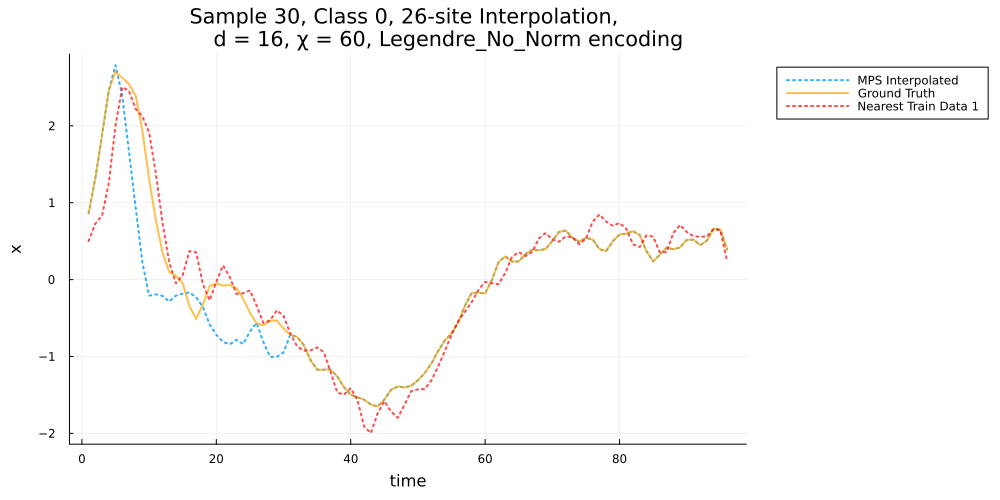

In [38]:
max_jump=0.5
class = 0
interp_sites = collect(5:30)
instance_idx = 30
stats, p1_ns = any_interpolate_single_timeseries(fc_ns, class, instance_idx, interp_sites, :directMode; NN_baseline=true, X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it, max_jump=max_jump);


pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)


In [14]:
n1s = sum(y_test)
n0s = length(y_test) - n1s

n_each = 6
samples = [shuffle(1:n0s)[1:n_each]; shuffle(1:n1s)[1:n_each]]
interp_sites = collect(3:50)


48-element Vector{Int64}:
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
  ⋮
 42
 43
 44
 45
 46
 47
 48
 49
 50

In [32]:
classes = [zeros(Int,n_each); ones(Int,n_each)]
max_jump=1
ps = []
stats = []
for (i,s) in enumerate(samples)
    class = classes[i]
    instance_idx = s
    stat, p1 = any_interpolate_single_timeseries(fc_ns, class, instance_idx, interp_sites, :directMode; NN_baseline=true, X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it, max_jump=max_jump);
    push!(ps, p1...)
    push!(stats, stat)
end

In [33]:
stats_df = vcat(DataFrame.(stats)...)
@show describe(stats_df);


describe(stats_df) = 2×7 DataFrame
 Row │ variable  mean      min       median   max       nmissing  eltype
     │ Symbol    Float64   Float64   Float64  Float64   Int64     DataType
─────┼─────────────────────────────────────────────────────────────────────
   1 │ MAE       0.328867  0.117804  0.22893  0.884597         0  Float64
   2 │ NN_MAE    0.28781   0.119117  0.24071  0.54862          0  Float64


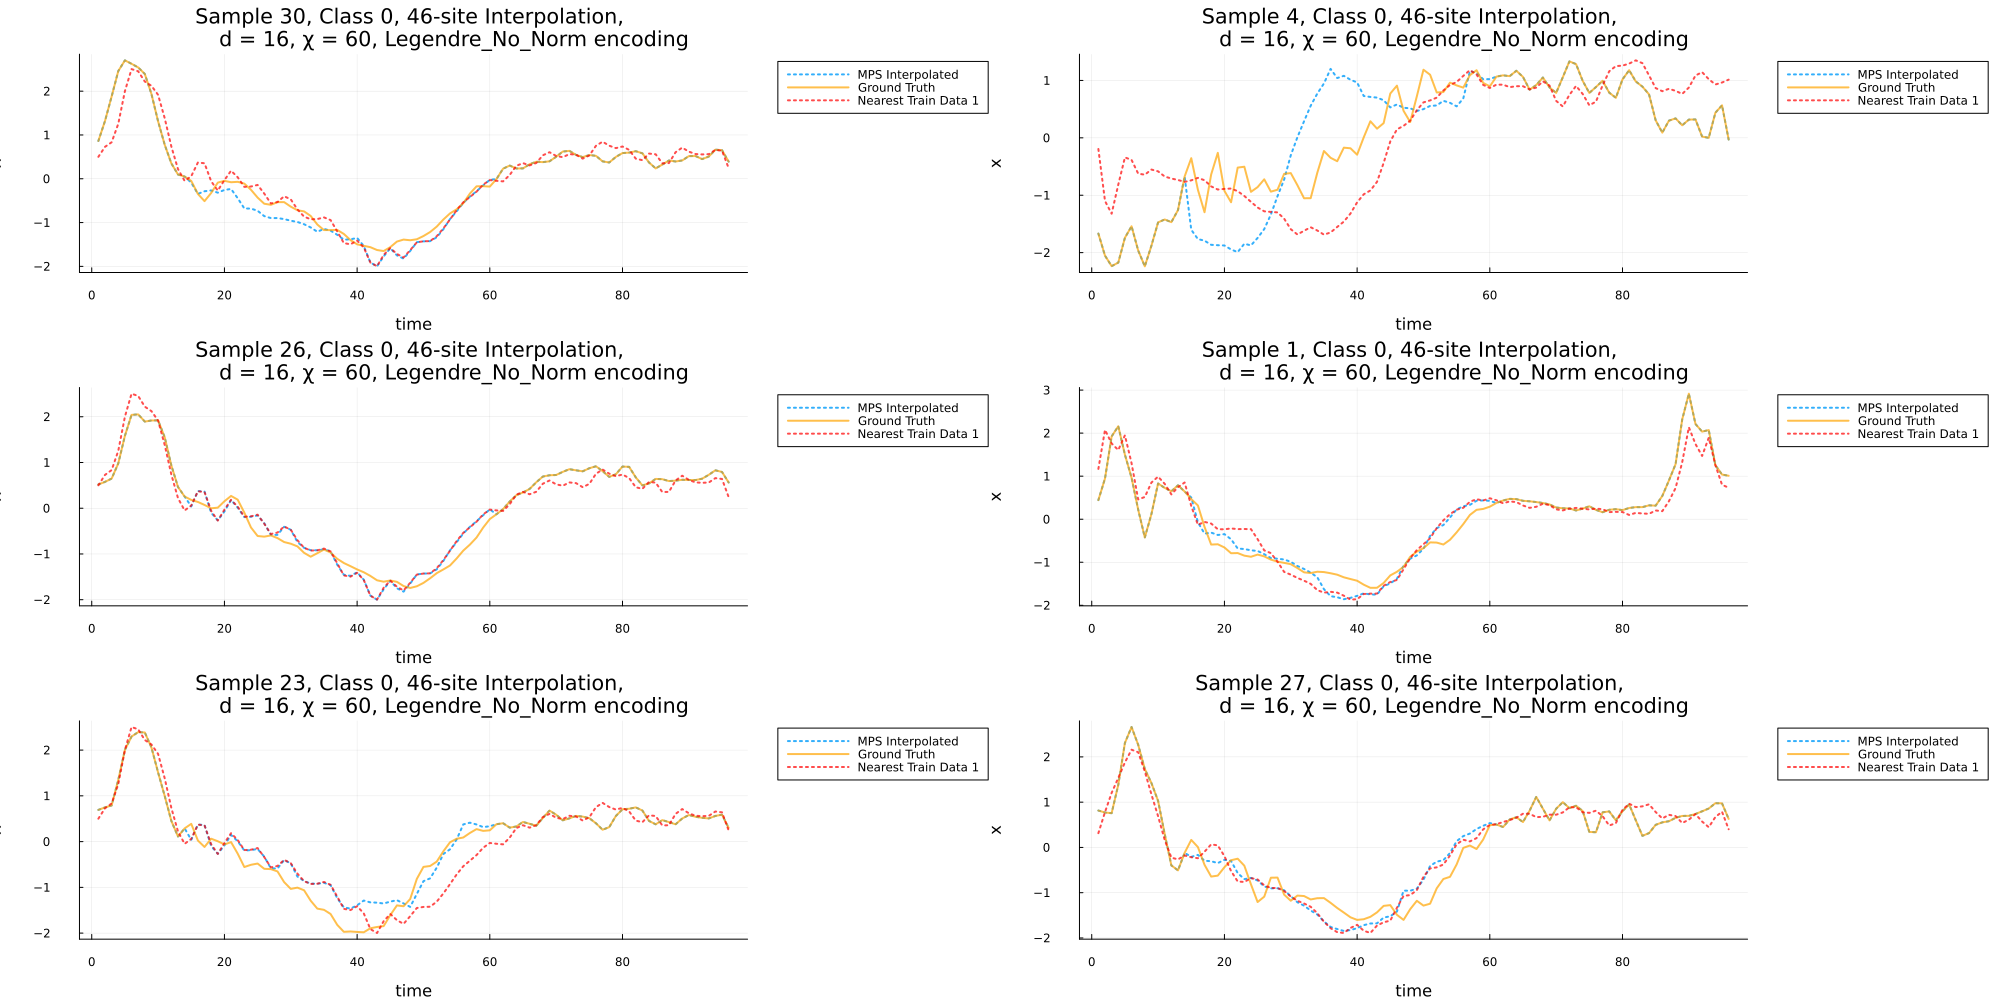

In [34]:
p1 = plot(ps[1:6]..., size=(2000,1000), layout=(3,2))
# savefig(p1, "figs/c0ecg.svg")

p2 = plot(ps[7:12]..., size=(2000,1000), layout=(3,2))
# savefig(p2, "figs/c1ecg.svg")
p1


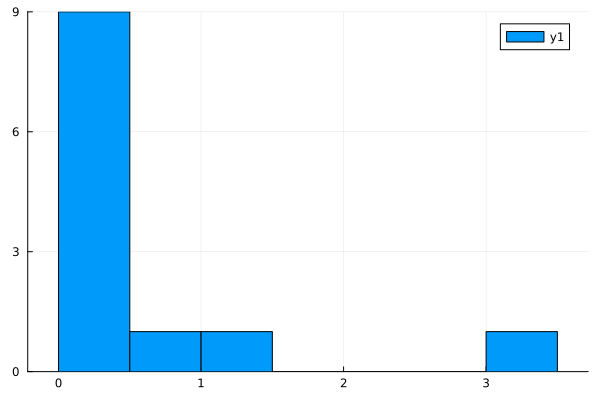

In [20]:
stats_df[!,:MAE] |> histogram

In [21]:
stats

12-element Vector{Any}:
 Dict(:MAE => 0.2487458177093749, :NN_MAE => 0.2525664809375)
 Dict(:MAE => 3.4066714487479164, :NN_MAE => 0.7396317323145837)
 Dict(:MAE => 0.20311522081614589, :NN_MAE => 0.199354045675)
 Dict(:MAE => 0.4379028027416667, :NN_MAE => 0.2989861118958333)
 Dict(:MAE => 0.22927864022239575, :NN_MAE => 0.25427458202500003)
 Dict(:MAE => 0.15723803143906243, :NN_MAE => 0.25365291451666655)
 Dict(:MAE => 0.3177633950364583, :NN_MAE => 0.3540636992500001)
 Dict(:MAE => 0.6834292298421872, :NN_MAE => 0.32951707937499997)
 Dict(:MAE => 1.1353143391213543, :NN_MAE => 0.22876425692500005)
 Dict(:MAE => 0.15705915677031235, :NN_MAE => 0.19482406961874998)
 Dict(:MAE => 0.21329826070052058, :NN_MAE => 0.20131589824374996)
 Dict(:MAE => 0.4193162670036458, :NN_MAE => 0.23844307487499997)

In [22]:
samples

12-element Vector{Int64}:
 30
  4
 26
  1
 23
 27
 30
 59
 13
  8
 63
 24

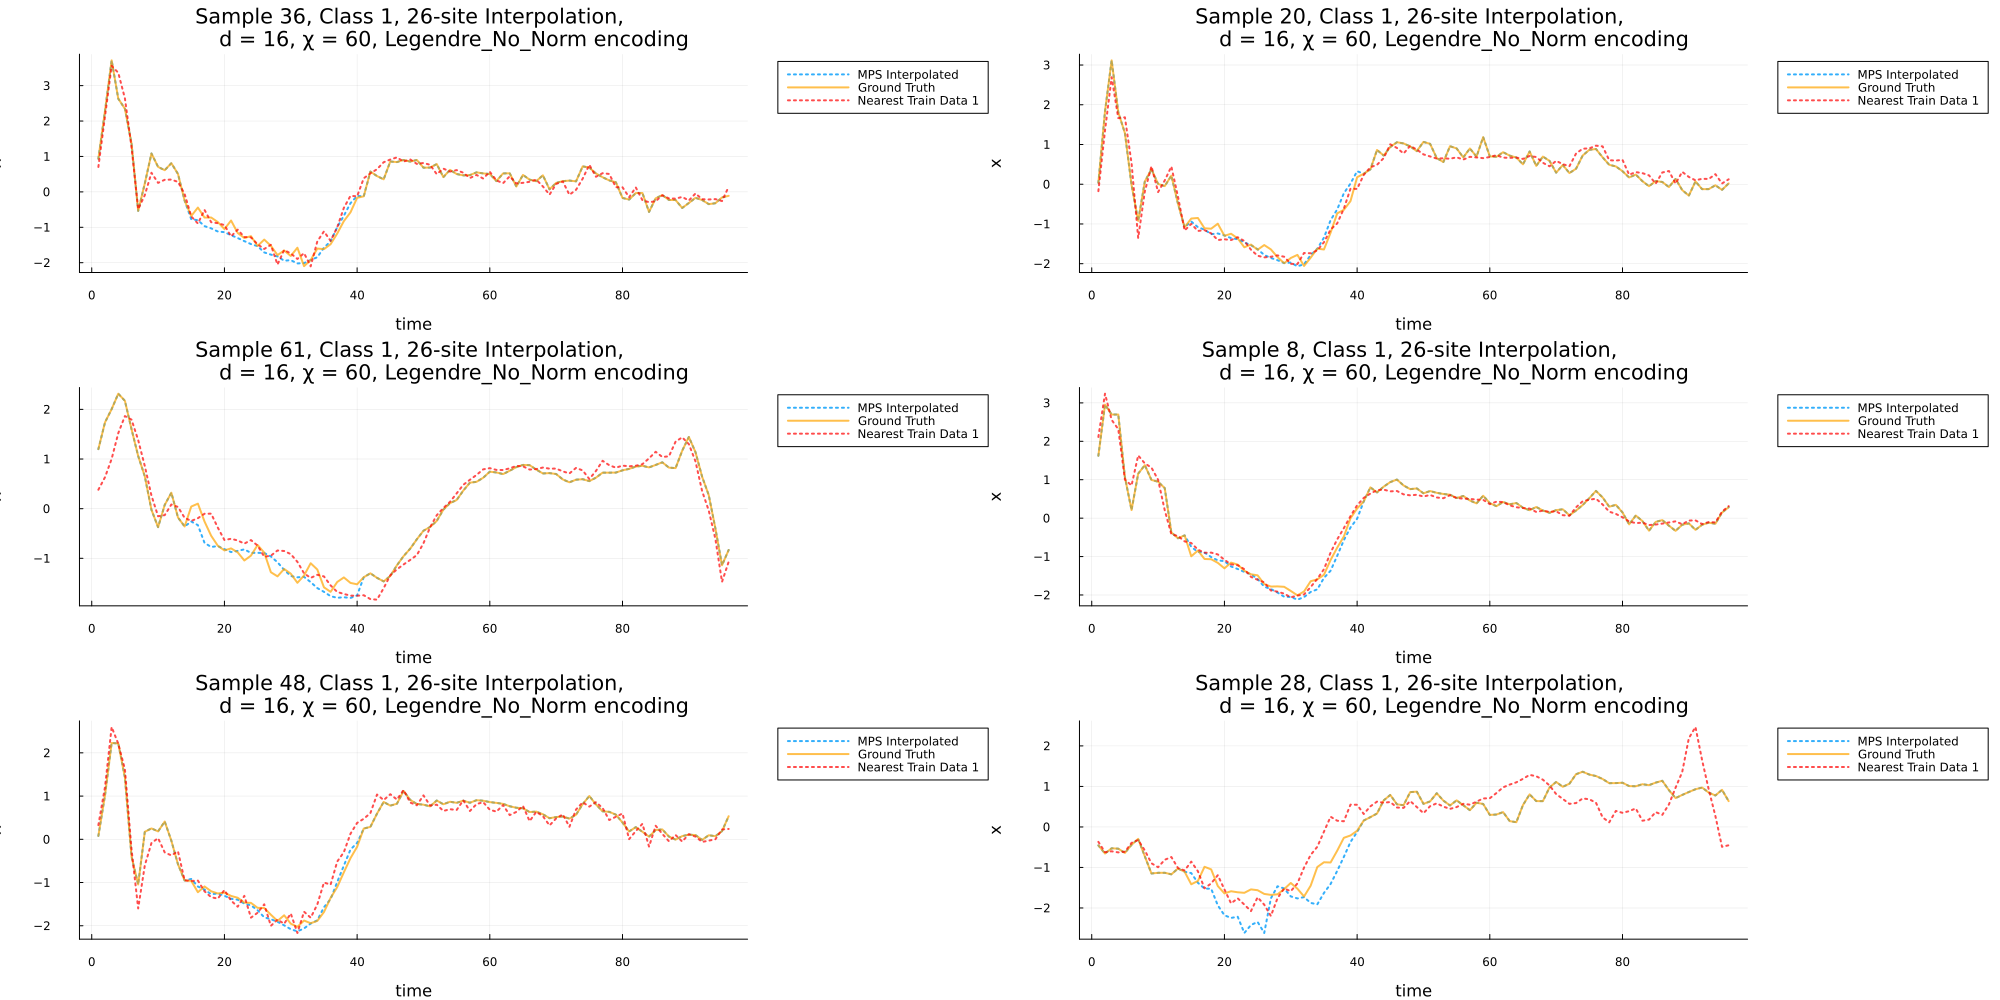

In [23]:
p2